# Test Manhattan Cross Junction
Test and experiment with Manhattan cross-junction geometry.

**Structure:**
- 2 straight bandage leads (contact pads)
- 2 angled leads at 45° that cross
- Junction gap at crossing point
- Paddle-shaped undercut borders

Edit the function below to customize your design!

In [4]:
# Setup
import sys
import os
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'multimode'))

from typing import Tuple
from phidl import Device, quickplot as qp
from phidl_bridge import Chip, Structure, CPWStraight
import phidl_bridge
import numpy as np

## Manhattan Junction Function

**Edit this function to customize the junction geometry!**

Change parameters like `bandage_w`, `bandage_l`, `angle_w`, `angle_l`, `gap`, `uc` to adjust the design.

In [ ]:
def draw_rectangle_cpw(pin_chip, gap_chip, center_pos: Tuple[float, float],
                       width: float, length: float,
                       direction: float,
                       paddle_width: float = 1.0,
                       paddle_length: float = 1.5,
                       uc: float = 0.15) -> None:
    """
    Draw a solid rectangle with paddles at ends and side undercut borders.

    Args:
        pin_chip: Chip object for main rectangle (PIN layer)
        gap_chip: Chip object for paddles and side undercut (GAP/undercut layer)
        center_pos: (x, y) center position of rectangle
        width: Rectangle width (perpendicular to direction)
        length: Rectangle length (along direction)
        direction: Angle in degrees (0=horizontal, 90=vertical, 45/−45=diagonal)
        paddle_width: Paddle width (default 1.0 µm)
        paddle_length: Paddle length (default 1.5 µm)
        uc: Undercut border width (default 0.15 µm = 150 nm)

    Draws:
        - Main rectangle on pin_chip (fullcut metal)
        - Paddles at both ends on gap_chip (undercut)
        - Side undercut borders (150 nm width) along rectangle edges (between paddles)
    """
    # Save original layer setting
    orig_layer_pin = phidl_bridge.LAYER_PIN

    theta_rad = np.radians(direction)

    # Draw main rectangle on PIN chip (centered at center_pos)
    half_dx = (length / 2) * np.cos(theta_rad)
    half_dy = (length / 2) * np.sin(theta_rad)
    start_pos = (center_pos[0] - half_dx, center_pos[1] - half_dy)

    s_main = Structure(pin_chip, start=start_pos, direction=direction)
    CPWStraight(s_main, pinw=0, gapw=width/2, length=length)

    # Switch to GAP layer for undercut features
    phidl_bridge.LAYER_PIN = phidl_bridge.LAYER_GAP

    # Calculate positions for undercut features
    paddle_half_dx = (paddle_length / 2) * np.cos(theta_rad)
    paddle_half_dy = (paddle_length / 2) * np.sin(theta_rad)

    # Left paddle (at start end)
    left_center = (center_pos[0] - half_dx, center_pos[1] - half_dy)
    left_start = (left_center[0] - paddle_half_dx, left_center[1] - paddle_half_dy)
    s_left = Structure(gap_chip, start=left_start, direction=direction)
    CPWStraight(s_left, pinw=0, gapw=paddle_width/2, length=paddle_length)

    # Side undercut borders (between paddles, along rectangle edges)
    # Start just after left paddle, end just before right paddle
    side_start_x = center_pos[0] - half_dx + (paddle_length/2) * np.cos(theta_rad)
    side_start_y = center_pos[1] - half_dy + (paddle_length/2) * np.sin(theta_rad)
    side_length = length - paddle_length

    s_side = Structure(gap_chip, start=(side_start_x, side_start_y), direction=direction)
    CPWStraight(s_side, pinw=width, gapw=uc/2, length=side_length)

    # Right paddle (at end end)
    right_center = (center_pos[0] + half_dx, center_pos[1] + half_dy)
    right_start = (right_center[0] - paddle_half_dx, right_center[1] - paddle_half_dy)
    s_right = Structure(gap_chip, start=right_start, direction=direction)
    CPWStraight(s_right, pinw=0, gapw=paddle_width/2, length=paddle_length)

    # Restore original layer
    phidl_bridge.LAYER_PIN = orig_layer_pin


def draw_manhattan_junction(width: float,
                            layer_pin: int, layer_gap: int) -> Tuple[Device, Device]:
    """
    Draw a Manhattan cross junction using phidl_bridge stateful API.
    
    Structure:
    - 2 straight bandage leads (horizontal contact pads)
    - 2 angled leads at 45°/135° that cross
    - Junction gap at crossing point
    - Paddle-shaped undercut at all lead ends
    """
    # Save original layer settings
    orig_pin = phidl_bridge.LAYER_PIN
    orig_gap = phidl_bridge.LAYER_GAP
    
    # =========================================================================
    # GEOMETRY PARAMETERS - Edit these to customize!
    # =========================================================================
    bandage_w = 0.2       # Bandage width (um)
    bandage_l = 20        # Bandage length (um)
    angle_w = width       # Angled lead width (um)
    angle_l = 10          # Angled lead length (um)
    uc = 0.15             # Undercut border width (um) = 150 nm
    hor_offset = 1.5      # Horizontal spacing between bandages (um)
    ver_offset = 1        # Vertical spacing between bandages (um)
    
    try:
        phidl_bridge.LAYER_PIN = layer_pin
        phidl_bridge.LAYER_GAP = layer_gap
        
        pin_chip = Chip('pin_temp', size=(20, 20), two_layer=False)
        gap_chip = Chip('gap_temp', size=(20, 20), two_layer=False)
        
        # =====================================================================
        # DRAW GEOMETRY - 2 bandages + 2 angled leads
        # =====================================================================
        
        # Bandage 1: Left horizontal lead
        pos1 = (-hor_offset - bandage_l/2, 0)
        draw_rectangle_cpw(pin_chip, gap_chip, pos1, 
                          width=bandage_w, length=bandage_l, direction=0, uc=uc)
        
        # Bandage 2: Right horizontal lead (offset vertically)
        pos2 = (hor_offset + bandage_l/2, -ver_offset)
        draw_rectangle_cpw(pin_chip, gap_chip, pos2, 
                          width=bandage_w, length=bandage_l, direction=0, uc=uc)
        
        # Angled lead 1: 45° diagonal
        pos3 = (-2*hor_offset, 2*hor_offset/3)
        draw_rectangle_cpw(pin_chip, gap_chip, pos3, 
                          width=angle_w, length=1.25*angle_l, direction=45, uc=uc)
        
        # Angled lead 2: 135° diagonal (perpendicular to lead 1)
        pos4 = (2*hor_offset, hor_offset - ver_offset)
        draw_rectangle_cpw(pin_chip, gap_chip, pos4, 
                          width=angle_w, length=1.25*angle_l, direction=135, uc=uc)
        
        # Center and return devices
        pin_dev = pin_chip.device
        gap_dev = gap_chip.device
        pin_dev.move(origin=pin_dev.center, destination=(0, 0))
        gap_dev.move(origin=gap_dev.center, destination=(0, 0))
        
        return pin_dev, gap_dev
    
    finally:
        phidl_bridge.LAYER_PIN = orig_pin
        phidl_bridge.LAYER_GAP = orig_gap


## Test Basic Junction

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


PIN device: 4 polygons, layers: {20}
GAP device: 8 polygons, layers: {20}


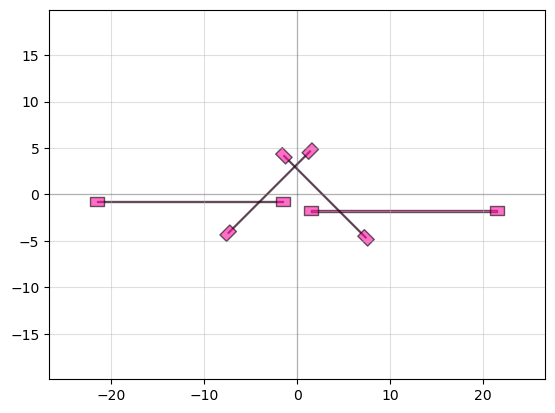

In [68]:
# Test with standard parameters
pin_dev, gap_dev = draw_manhattan_junction(
    width=0.1,     # Junction width (um)
    gap=0.20,       # Junction gap (um)
    layer_pin=20,   # PIN layer
    layer_gap=60    # GAP layer
)

print(f"PIN device: {len(pin_dev.polygons)} polygons, layers: {set(p.layers[0] for p in pin_dev.polygons)}")
print(f"GAP device: {len(gap_dev.polygons)} polygons, layers: {set(p.layers[0] for p in gap_dev.polygons)}")

# Combine for visualization
combined = Device('manhattan_test')
combined << pin_dev
combined << gap_dev

qp(combined)

## View Layers Separately

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


PIN layer (fullcut):


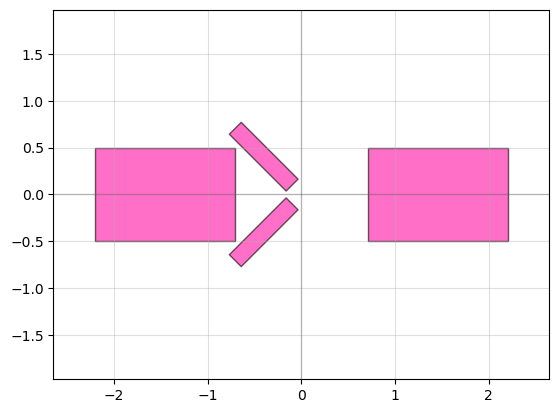

In [7]:
# View PIN layer only (fullcut - metal features)
print("PIN layer (fullcut):")
qp(pin_dev)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


GAP layer (undercut):


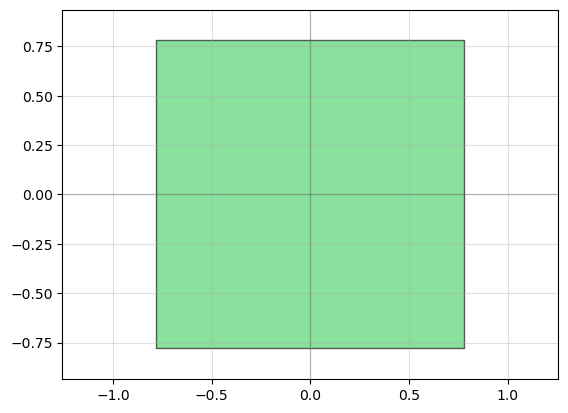

In [8]:
# View GAP layer only (undercut borders)
print("GAP layer (undercut):")
qp(gap_dev)

## Parameter Sweep: Junction Width

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.



--- Width: 0.1 um ---
Total size: 4.41 x 1.48 um


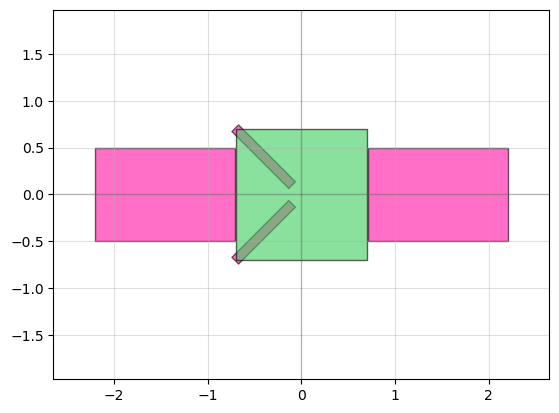

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.



--- Width: 0.18 um ---
Total size: 4.41 x 1.56 um


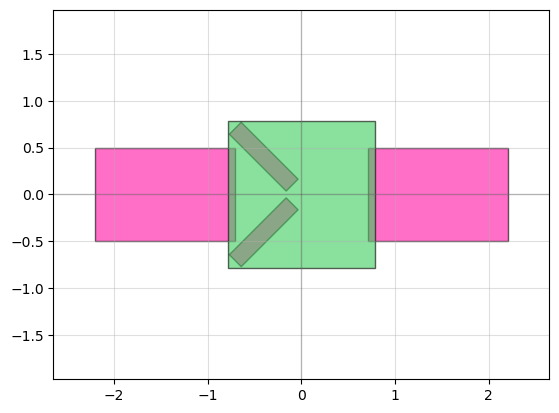

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.



--- Width: 0.3 um ---
Total size: 4.41 x 1.80 um


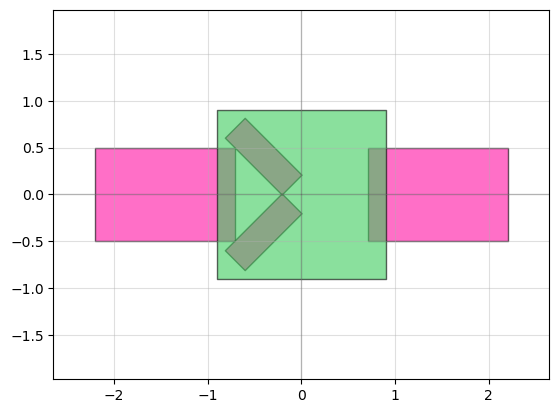

In [9]:
# Test different junction widths
widths = [0.10, 0.18, 0.30]

for w in widths:
    print(f"\n--- Width: {w} um ---")
    pin_dev, gap_dev = draw_manhattan_junction(
        width=w,
        gap=0.20,
        layer_pin=20,
        layer_gap=60
    )
    
    combined = Device(f'manhattan_w{w}')
    combined << pin_dev
    combined << gap_dev
    
    print(f"Total size: {combined.xsize:.2f} x {combined.ysize:.2f} um")
    qp(combined)

## Parameter Sweep: Junction Gap

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.



--- Gap: 0.1 um ---
Total size: 4.41 x 1.54 um


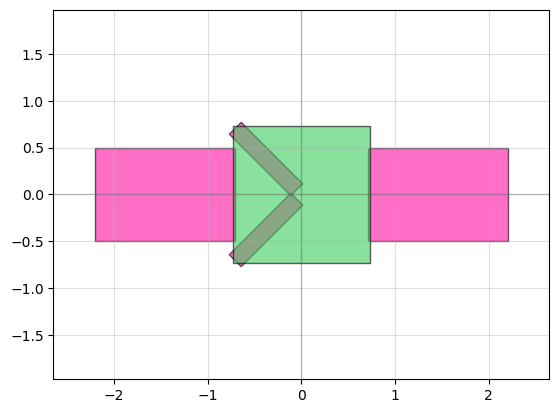

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.



--- Gap: 0.2 um ---
Total size: 4.41 x 1.56 um


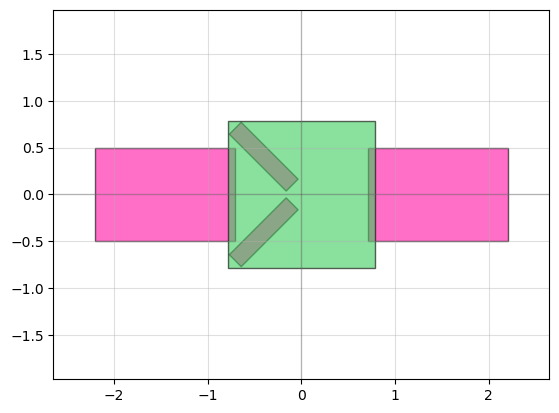

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.



--- Gap: 0.3 um ---
Total size: 4.41 x 1.66 um


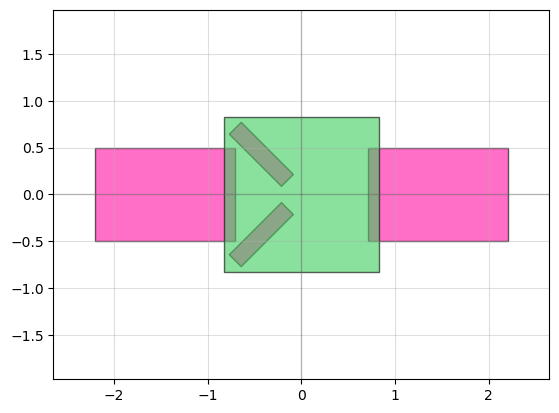

In [10]:
# Test different junction gaps
gaps = [0.10, 0.20, 0.30]

for g in gaps:
    print(f"\n--- Gap: {g} um ---")
    pin_dev, gap_dev = draw_manhattan_junction(
        width=0.18,
        gap=g,
        layer_pin=20,
        layer_gap=60
    )
    
    combined = Device(f'manhattan_g{g}')
    combined << pin_dev
    combined << gap_dev
    
    print(f"Total size: {combined.xsize:.2f} x {combined.ysize:.2f} um")
    qp(combined)

## Save Test Output

In [11]:
# Save for inspection in KLayout
pin_dev, gap_dev = draw_manhattan_junction(
    width=0.18, gap=0.20, layer_pin=20, layer_gap=60
)

combined = Device('manhattan_test')
combined << pin_dev
combined << gap_dev

combined.write_gds('test_manhattan_junction.gds')
print("Saved: test_manhattan_junction.gds")
print(f"Open with: klayout test_manhattan_junction.gds")

Saved: test_manhattan_junction.gds
Open with: klayout test_manhattan_junction.gds


## Geometry Analysis

In [12]:
# Analyze geometry
print("PIN Layer Polygons:")
for i, poly in enumerate(pin_dev.polygons):
    print(f"  Polygon {i+1}: Layer {poly.layers[0]}, {len(poly.points)} vertices")

print("\nGAP Layer Polygons:")
for i, poly in enumerate(gap_dev.polygons):
    print(f"  Polygon {i+1}: Layer {poly.layers[0]}, {len(poly.points)} vertices")

print(f"\nTotal device size: {combined.xsize:.2f} x {combined.ysize:.2f} um")
print(f"Device center: ({combined.center[0]:.2f}, {combined.center[1]:.2f})")

PIN Layer Polygons:


AttributeError: 'Polygon' object has no attribute 'points'